# Experiments on MNIST

In [1]:
from optimizers import *

import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline

import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
file_path = "./MNIST"
batch_size = 4

## Data

In [4]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='../data', 
                                      train=True, download=True, transform=transform)
valid_dataset = torchvision.datasets.MNIST(root='../data', 
                                           train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='../data', 
                                     train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [5]:
valid_size=0.15
num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

np.random.seed(42)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(trainset, 
               batch_size=batch_size, sampler=train_sampler,
               num_workers=2)

validloader = torch.utils.data.DataLoader(valid_dataset, 
               batch_size=batch_size, sampler=valid_sampler,
               num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels:  tensor([7, 1, 8, 2])
Batch shape:  torch.Size([4, 1, 28, 28])


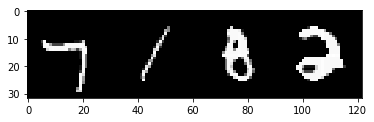

In [6]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

print('Labels: ', labels)
print('Batch shape: ', images.size())
show_batch(images)

## Models

### Logistic Regression

In [7]:
class LR(nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.linear1 = nn.Linear(28*28, 10)

    def forward(self, x):
        y_pred = F.log_softmax(self.linear1(x.view(batch_size, -1)), -1)
        return y_pred

###   Two-layer neural network (fully connected)

In [8]:
class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()
        self.linear1 = nn.Linear(28*28, 256)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        h_relu = F.relu(self.linear1(x.view(batch_size, -1)))
        y_pred = self.linear2(h_relu)
        return y_pred

## Train

In [9]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def model_step(model, optimizer, criterion, inputs, labels):
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    if model.training:
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
    if optimizer.__class__.__name__ != 'SUG':
        optimizer.step()
    else:
        def closure():
            optimizer.zero_grad()
            upd_outputs = model(inputs)
            upd_loss = criterion(upd_outputs, labels)
            upd_loss.backward()
            return upd_loss

        optimizer.step(loss, closure)

    return loss.item()

In [10]:
def train(model, trainloader, criterion, optimizer, n_epochs=2, validloader=None, eps=1e-5, print_every=1):
    tr_loss, val_loss, lips, times, grad, acc = ([] for i in range(6))
    start_time = time.time()
    model.to(device=device)
    for ep in range(n_epochs):
        model.train()
        i = 0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device=device), Variable(labels).to(device=device)

            tr_loss.append(model_step(model, optimizer, criterion, inputs, labels))
            if optimizer.__class__.__name__ == 'SUG':
                lips.append(optimizer.get_lipsitz_const())
                grad.append(optimizer.get_sq_grad)
        times.append(time_since(start_time))
        if ep % print_every == 0:
            print("Epoch {}, training loss {}, time passed {}".format(ep, sum(tr_loss[-i:]) / i, time_since(start_time)))

        if validloader is None:
            continue
        model.zero_grad()
        model.eval()
        j = 0
        for j, data in enumerate(validloader):
            inputs, labels = data
            inputs, labels = inputs.to(device=device), labels.to(device=device)
            val_loss.append(model_step(model, optimizer, criterion, inputs, labels))
        if ep % print_every == 0:
            print("Validation loss {}".format(sum(val_loss[-j:]) / j))
        
    return tr_loss, times, val_loss, lips, grad

In [17]:
print_every = 2
n_epochs = 6
tr_loss = {}
tr_loss['accSGD'] = {}
tr_loss['Adam'] = {}
tr_loss['amsgrad'] = {}
tr_loss['sug'] = {}
tr_loss['A2GradInc'] = {}
tr_loss['A2GradUni'] = {}
tr_loss['A2GradExp'] = {}
val_loss = {}
val_loss['accSGD'] = {}
val_loss['Adam'] = {}
val_loss['amsgrad'] = {}
val_loss['sug'] = {}
val_loss['A2GradInc'] = {}
val_loss['A2GradUni'] = {}
val_loss['A2GradExp'] = {}
lrs = [0.001]#[0.1, 0.01, 0.001]
criterion = nn.CrossEntropyLoss(reduction="mean")

In [12]:
def concat_states(state1, state2):
    states = {
            'epoch': state1['epoch'] + state2['epoch'],
            'state_dict': state2['state_dict'],
            'optimizer': state2['optimizer'],
            'tr_loss' : state1['tr_loss'] + state2['tr_loss'],
            'val_loss' : state1['val_loss'] + state2['val_loss'],
            'lips' : state1['lips'] + state2['lips'],
            'grad' : state1['grad'] + state2['grad'],
            #'times' : state1['times'] + list(map(lambda x: x + state1['times'][-1],state2['times']))
             'times' : state1['times'] + state2['times']
             }
    return states

### LR

#### Adam 

In [16]:
for lr in lrs:
    model = LR()
    print("Adam  lr={}:".format(lr))
    optimizer = optim.Adam(model.parameters(), lr=lr)
    tr_loss['Adam'][lr], times, val_loss['Adam'][lr], lips, grad = train(model, trainloader, criterion, 
                                                                         optimizer, n_epochs=n_epochs, 
                                                                         print_every=print_every, 
                                                                         validloader=validloader)
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['Adam'][lr],
            'val_loss' : val_loss['Adam'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times
             }
    torch.save(states, './MNIST/LR_Adam_' + str(lr))

Adam  lr=0.001:
Epoch 0, training loss 0.4471673777217208, time passed 0m 17s
Validation loss 0.48481341447177106
Epoch 2, training loss 0.39360389989321554, time passed 0m 54s
Validation loss 0.4692441363024516
Epoch 4, training loss 0.38341145817109673, time passed 1m 35s
Validation loss 0.5846125006058818


#### A2GradInc 

In [13]:
for lr in lrs:
    model = LR()
    print('A2GradInc')
    optimizer = A2GradInc(model.parameters())
    tr_loss['A2GradInc'][lr], times, val_loss['A2GradInc'][lr], lips, grad = train(model, trainloader, criterion, 
                                                                         optimizer, n_epochs=n_epochs, 
                                                                         print_every=print_every, 
                                                                         validloader=validloader)
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['A2GradInc'][lr],
            'val_loss' : val_loss['A2GradInc'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times
             }
    torch.save(states, './MNIST/LR_A2GradInc')

A2GradInc
Epoch 0, training loss 0.6602763776485593, time passed 0m 21s
Validation loss 0.5054242114502093
Epoch 2, training loss 0.4349289565605807, time passed 1m 2s
Validation loss 0.4237436142879699
Epoch 4, training loss 0.400614009719051, time passed 1m 48s
Validation loss 0.3957431950432896


#### A2GradExp

In [22]:
for lr in lrs:
    model = LR()
    print("A2GradExp  lr={}:".format(lr))
    optimizer = A2GradExp(model.parameters(), beta=10, lips=10, rho=0.9)
    tr_loss['A2GradExp'][lr], times, val_loss['A2GradExp'][lr], lips, grad = train(model, trainloader, criterion, 
                                                                         optimizer, n_epochs=n_epochs, 
                                                                         print_every=print_every, 
                                                                         validloader=validloader)
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['A2GradExp'][lr],
            'val_loss' : val_loss['A2GradExp'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times
             }
    torch.save(states, './MNIST/LR_A2GradExp')

A2GradExp  lr=0.001:
Epoch 0, training loss 0.890304833246765, time passed 0m 16s
Validation loss 0.6959082544174604
Epoch 2, training loss 0.5943733410107238, time passed 1m 4s
Validation loss 0.5783207188677183
Epoch 4, training loss 0.5419563035308936, time passed 1m 45s
Validation loss 0.5347908401390535


#### A2GradUni

In [18]:
for lr in lrs:
    model = LR()
    print("A2GradUni  lr={}:".format(lr))
    optimizer = A2GradUni(model.parameters())
    tr_loss['A2GradUni'][lr], times, val_loss['A2GradUni'][lr], lips, grad = train(model, trainloader, criterion, 
                                                                         optimizer, n_epochs=n_epochs, 
                                                                         print_every=print_every, 
                                                                         validloader=validloader)
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['A2GradUni'][lr],
            'val_loss' : val_loss['A2GradUni'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times
             }
    torch.save(states, './MNIST/LR_A2GradUni')

A2GradUni  lr=0.001:
Epoch 0, training loss 0.8777040629732776, time passed 0m 21s
Validation loss 0.6466419323036516
Epoch 2, training loss 0.5362675025063032, time passed 1m 2s
Validation loss 0.5200954246636614
Epoch 4, training loss 0.4826502767078481, time passed 1m 52s
Validation loss 0.47515102096064293


#### AMSgrad

In [17]:
for lr in lrs:
    model = LR()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99), eps=1e-8, amsgrad=True)
    tr_loss['amsgrad'], times, val_loss['amsgrad'], lips, grad = train(model, trainloader, criterion, optimizer, 
                                                           n_epochs=n_epochs, print_every=print_every, 
                                                           validloader=validloader)
                                                         
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['amsgrad'],
            'val_loss' : val_loss['amsgrad'],
            'lips' : lips,
            'grad' : grad,
            'times' : times
         }
    torch.save(states, './MNIST/LR_amsgrad')

Epoch 0, training loss 0.4065497466627148, time passed 0m 19s
Validation loss 0.42612661495290843
Epoch 2, training loss 0.32533949986387606, time passed 1m 10s
Validation loss 0.37711557346290964
Epoch 4, training loss 0.31078923913632767, time passed 1m 55s
Validation loss 0.3057402240929971


#### Accelerated SGD

In [18]:
model = LR()
optimizer = AccSGD(model.parameters(), lr=0.001, kappa = 1000.0, xi = 10.0)
tr_loss['accSGD'], times, val_loss['accSGD'], lips, grad = train(model, trainloader, criterion, optimizer, 
                                                           n_epochs=n_epochs, print_every=print_every, 
                                                           validloader=validloader)
                                          
states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['accSGD'],
            'val_loss' : val_loss['accSGD'],
            'lips' : lips,
            'grad' : grad,
            'times' : times
         }
torch.save(states, './MNIST/LR_accSGD')

Epoch 0, training loss 0.40764180013083695, time passed 0m 20s
Validation loss 0.40028829447166864
Epoch 2, training loss 0.30266382122565666, time passed 1m 7s
Validation loss 0.36440590935486555
Epoch 4, training loss 0.28831493548777254, time passed 1m 53s
Validation loss 0.31914368522866027


#### Adaptive SGD

In [18]:
for lr in lrs:
    model = LR()
    optimizer = SUG(model.parameters(), l_0=lr, momentum=0, nesterov=False)
    tr_loss['sug'], times, val_loss['sug'], lips, grad = train(model, trainloader, criterion, optimizer, 
                                                           n_epochs=n_epochs, print_every=print_every, 
                                                           validloader=validloader)
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sug'],
            'val_loss' : val_loss['sug'],
            'lips' : lips,
            'grad' : grad,
            'times' : times
         }
    torch.save(states, './MNIST/LR_sug')

Epoch 0, training loss 0.4637937442886873, time passed 0m 31s
Validation loss 0.4307740188288825
Epoch 2, training loss 0.38815918782290354, time passed 1m 32s
Validation loss 0.43152904974208994
Epoch 4, training loss 0.38372424873438565, time passed 2m 27s
Validation loss 0.4823033701936678


### FC neural network

In [19]:
n_epochs = 8

#### Adam

In [23]:
for lr in lrs:
    model = FC()
    print("Adam  lr={}:".format(lr))
    optimizer = optim.Adam(model.parameters(), lr=lr)
    tr_loss['Adam'][lr], times, val_loss['Adam'][lr], lips, grad = train(model, trainloader, criterion, 
                                                                         optimizer, n_epochs=n_epochs, 
                                                                         print_every=print_every, 
                                                                         validloader=validloader)
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['Adam'][lr],
            'val_loss' : val_loss['Adam'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times
             }
    torch.save(states, './MNIST/FC_Adam_' + str(lr))

Adam  lr=0.001:
Epoch 0, training loss 0.31472805445884217, time passed 2m 17s
Validation loss 0.33562005795256833
Epoch 2, training loss 0.1640293464746599, time passed 7m 56s
Validation loss 0.16987620446443386
Epoch 4, training loss 0.1375037254112192, time passed 13m 44s
Validation loss 0.1692539849275083
Epoch 6, training loss 0.12588283565029146, time passed 20m 30s
Validation loss 0.17024462949287886


#### AMSgrad

In [24]:
for lr in lrs:
    model = FC()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99), eps=1e-8, amsgrad=True)
    tr_loss['amsgrad'], times, val_loss['amsgrad'], lips, grad = train(model, trainloader, criterion, optimizer, 
                                                           n_epochs=n_epochs, print_every=print_every, 
                                                           validloader=validloader)
                                                         
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['amsgrad'],
            'val_loss' : val_loss['amsgrad'],
            'lips' : lips,
            'grad' : grad,
            'times' : times
         }
    torch.save(states, './MNIST/FC_amsgrad')

Epoch 0, training loss 0.2954024291499492, time passed 2m 8s
Validation loss 0.19679289057075633
Epoch 2, training loss 0.11406174258036991, time passed 7m 39s
Validation loss 0.14818219451598985
Epoch 4, training loss 0.07966713166552923, time passed 13m 13s
Validation loss 0.10309265803739515
Epoch 6, training loss 0.06052994809905093, time passed 18m 52s
Validation loss 0.10621145213906528


#### Accelerated SGD

In [25]:
model = FC()
optimizer = AccSGD(model.parameters(), lr=0.001, kappa = 1000.0, xi = 10.0)
tr_loss['accSGD'], times, val_loss['accSGD'], lips, grad = train(model, trainloader, criterion, optimizer, 
                                                           n_epochs=n_epochs, print_every=print_every, 
                                                           validloader=validloader)
                                          
states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['accSGD'],
            'val_loss' : val_loss['accSGD'],
            'lips' : lips,
            'grad' : grad,
            'times' : times
         }
torch.save(states, './MNIST/FC_accSGD')

Epoch 0, training loss 0.4004168582505848, time passed 0m 36s
Validation loss 0.26797187960428787
Epoch 2, training loss 0.15343301741924836, time passed 1m 55s
Validation loss 0.17337015810517428
Epoch 4, training loss 0.10210626035243803, time passed 3m 13s
Validation loss 0.1559533597549474
Epoch 6, training loss 0.07533009543270398, time passed 4m 37s
Validation loss 0.10859271298254157


#### Adaptive SGD

In [20]:
for lr in lrs:
    model = FC()
    optimizer = SUG(model.parameters(), l_0=lr, momentum=0, nesterov=False)
    tr_loss['sug'], times, val_loss['sug'], lips, grad = train(model, trainloader, criterion, optimizer, 
                                                           n_epochs=n_epochs, print_every=print_every, 
                                                           validloader=validloader)
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sug'],
            'val_loss' : val_loss['sug'],
            'lips' : lips,
            'grad' : grad,
            'times' : times
         }
    torch.save(states, './MNIST/FC_sug')

Epoch 0, training loss 0.31520323795340593, time passed 1m 18s
Validation loss 0.17935882584950086
Epoch 2, training loss 0.11782419556486382, time passed 4m 13s
Validation loss 0.11791805404194093
Epoch 4, training loss 0.08247277856162973, time passed 7m 37s
Validation loss 0.11297670972776604
Epoch 6, training loss 0.06494110676108814, time passed 10m 53s
Validation loss 0.11238901866388724


#### A2GradInc 

In [29]:
for lr in lrs:
    model = FC()
    print('A2GradInc')
    optimizer = A2GradInc(model.parameters(), beta=1, lips=10)
    tr_loss['A2GradInc'][lr], times, val_loss['A2GradInc'][lr], lips, grad = train(model, trainloader, criterion, 
                                                                         optimizer, n_epochs=n_epochs, 
                                                                         print_every=print_every, 
                                                                         validloader=validloader)
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['A2GradInc'][lr],
            'val_loss' : val_loss['A2GradInc'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times
             }
    torch.save(states, './MNIST/FC_A2GradInc')

A2GradInc
Epoch 0, training loss 0.3405313328328119, time passed 0m 50s
Validation loss 0.40539793937192486
Epoch 2, training loss 0.2502931321926777, time passed 2m 36s
Validation loss 0.25179623060090744
Epoch 4, training loss 0.19747851773686237, time passed 4m 52s
Validation loss 0.2213085105865465
Epoch 6, training loss 0.19407693164069398, time passed 6m 41s
Validation loss 0.20182552583856866


#### A2GradUni

In [28]:
for lr in lrs:
    model = FC()
    print("A2GradUni  lr={}:".format(lr))
    optimizer = A2GradUni(model.parameters(), beta=1, lips=10)
    tr_loss['A2GradUni'][lr], times, val_loss['A2GradUni'][lr], lips, grad = train(model, trainloader, criterion, 
                                                                         optimizer, n_epochs=n_epochs, 
                                                                         print_every=print_every, 
                                                                         validloader=validloader)
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['A2GradUni'][lr],
            'val_loss' : val_loss['A2GradUni'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times
             }
    torch.save(states, './MNIST/FC_A2GradUni')

A2GradUni  lr=0.001:
Epoch 0, training loss 0.3645090667142411, time passed 0m 49s
Validation loss 0.3461166744949872
Epoch 2, training loss 0.2715470625102375, time passed 2m 48s
Validation loss 0.25930503801856375
Epoch 4, training loss 0.21909287481441134, time passed 4m 37s
Validation loss 0.20832079588015273
Epoch 6, training loss 0.1821865990205095, time passed 6m 28s
Validation loss 0.17309671778210325


#### A2GradExp

In [30]:
for lr in lrs:
    model = FC()
    print("A2GradExp  lr={}:".format(lr))
    optimizer = A2GradExp(model.parameters(), beta=1, lips=5, rho=0.99)
    tr_loss['A2GradExp'][lr], times, val_loss['A2GradExp'][lr], lips, grad = train(model, trainloader, criterion, 
                                                                         optimizer, n_epochs=n_epochs, 
                                                                         print_every=print_every, 
                                                                         validloader=validloader)
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['A2GradExp'][lr],
            'val_loss' : val_loss['A2GradExp'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times
             }
    torch.save(states, './MNIST/FC_A2GradExp')

A2GradExp  lr=0.001:
Epoch 0, training loss 0.38943213840140223, time passed 0m 48s
Validation loss 0.3454775995363284
Epoch 2, training loss 0.289244648559167, time passed 2m 49s
Validation loss 0.28307165995922656
Epoch 4, training loss 0.2758141870881653, time passed 4m 34s
Validation loss 0.2541869924883675
Epoch 6, training loss 0.2549206986760371, time passed 6m 14s
Validation loss 0.2627989425029475
